In [1]:
import numpy as np
#import seaborn as sns
#import matplotlib.pyplot as plt
import csv
import pickle
from scipy import stats

import sys
sys.path.insert(1, '../../')
from utils import *

In [11]:
plt.rcParams.update({'font.size': 13})

In [2]:
#dataset = 'hospital'
#dataset = 'high_school'
#dataset = 'conference'
#dataset = 'workplace'
dataset = 'pr_school'

In [3]:
weighted = True

In [4]:
mu = 0.1
betaT = 0
if dataset == 'hospital':
    beta_range = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    R0_range = [1.20,1.53,1.77,2,2.22,2.38,2.56,2.7]

elif dataset == 'high_school':
    beta_range = [0.5,0.6,0.7,0.8,0.9,1.0]
    R0_range = [1.25,1.40,1.55,1.71,1.83,1.88]

elif dataset == 'workplace':
    beta_range = [0.3,0.4,0.5,0.6,0.7,0.8]
    R0_range = [1.26,1.55,1.82,2.06,2.22,2.40]

elif dataset == 'conference':
    beta_range = [0.6,0.7,0.8,0.9,1]
    R0_range = [1.21,1.37,1.49,1.60,1.74]
    
elif dataset == 'pr_school':
    beta_range = [0.12,0.15,0.18,0.21,0.24,0.27,0.3,0.33,0.36]
    R0_range = [1.40,1.65,1.97,2.11,2.31,2.48,2.68,2.84,3.01]

# Load C and obtain r and s:

C is an array of weights, I need to put it in a matrix shape to compute r and s

In [5]:
def obtain_r_s_indices(C,edgelist):
    # put C in dict:
    C_dict = {}
    n = 0
    for edge in edgelist:
        C_dict[tuple(edge)] = C[n]
        C_dict[tuple(edge[::-1])] = C[n+1]
        n += 2
    # verify:
    if list(C_dict.values()) != list(C):
        print('error')
    nb_nodes = max(np.unique(list(C_dict.keys()))) + 1
    # put C_dict in matrix:
    C_mat = np.zeros((nb_nodes,nb_nodes))
    for link in C_dict:
        C_mat[link[0],link[1]] = C_dict[link]

    # receiver index:
    r = C_mat.sum(axis=0) # somma di ogni colonna
    # spreader index:
    s = C_mat.sum(axis=1) # somma di ogni riga

    return r, s

In [6]:
with open('../../data/pairwise/' + dataset + '_strength_edgelist_pairwise_sorted.pkl', 'rb') as f:
    edgelist = pickle.load(f)

In [7]:
r_list = []
s_list = []
for beta in beta_range:
    filename = "results/inf_treeSIR/CL_mean_weighted_%s_beta_%.3f_betaT_%.3f_mu_%.2f_init_1.csv"%(dataset,beta,betaT,mu)
    C = load_C_mean(filename)
    # verify:
    if 2*len(edgelist) != len(C):
        print('errore')
    r, s = obtain_r_s_indices(C,edgelist)
    r_list.append(r)
    s_list.append(s)
    

In [8]:
#r_list[0]

# Cosine similarity

### Receiver index

In [9]:
sim_r = np.full((len(beta_range),len(beta_range)),0.0)
for i in range(len(beta_range)-1):
    for j in range(i+1,len(beta_range)):
        sim_r[i,j] = cos_sim(r_list[i],r_list[j] )

0.957989498165823 0.9997690061901607
../figs/simple_cos_sim_receiver_pr_school_mu_0.10.pdf.pdf


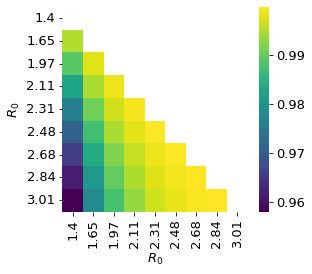

In [12]:
title='$r_i$ cosine sim.'
figname = '../figs/receiver_cos_sim_%s_mu_%.2f.pdf'%(dataset,mu)

plot_sim(sim_r, 
         mu, 
         R0_range,
         '$R_0$',
         save=True, 
         figname=figname, 
         scale='independent',
         min_scale=0, 
         max_scale=1)

### Spreader index

In [14]:
sim_s = np.full((len(beta_range),len(beta_range)),0.0)
for i in range(len(beta_range)-1):
    for j in range(i+1,len(beta_range)):
        sim_s[i,j] = cos_sim(s_list[i],s_list[j] )

0.9769079839906738 0.9992571505585242
../figs/simple_cos_sim_spreader_pr_school_mu_0.10.pdf.pdf


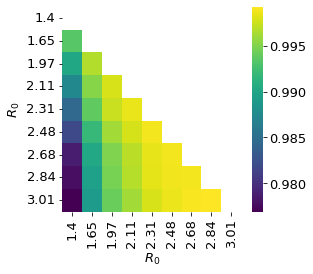

In [15]:
title='$s_i$ cosine sim.'
figname = '../figs/spreader_cos_sim_%s_mu_%.2f.pdf'%(dataset,mu)

plot_sim(sim_s, 
         mu, 
         R0_range,
         '$R_0$',
         save=True, 
         figname=figname, 
         scale='independent',
         min_scale=0, 
         max_scale=1)

# Ranking correlation

### Receiver index

In [17]:
corr_r = np.full((len(beta_range),len(beta_range)),0.0)
for i in range(len(beta_range)-1):
    for j in range(i+1,len(beta_range)):
        corr_r[i,j] = stats.spearmanr(np.array(r_list[i]),np.array(r_list[j])).correlation
        #corr_r[i,j] = stats.kendalltau(np.array(r_list[i]),np.array(r_list[j]))[0]

0.9312425129932278 0.9889065244649842
../figs/simple_rank_corr_receiver_pr_school_mu_0.10.pdf.pdf


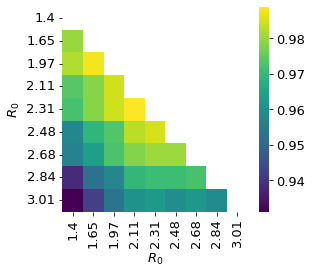

In [18]:
title='$r_i$ ranking corr.'
figname = '../figs/receiver_rank_corr_%s_mu_%.2f.pdf'%(dataset,mu)

plot_sim(corr_r, 
         mu, 
         R0_range,
         '$R_0$',
         save=True, 
         figname=figname, 
         scale='independent',
         min_scale=0, 
         max_scale=1)

### Spreader index

In [19]:
corr_s = np.full((len(beta_range),len(beta_range)),0.0)
for i in range(len(beta_range)-1):
    for j in range(i+1,len(beta_range)):
        corr_s[i,j] = stats.spearmanr(np.array(s_list[i]),np.array(s_list[j])).correlation
        #corr_s[i,j] = stats.kendalltau(np.array(s_list[i]),np.array(s_list[j]))[0]

0.9422228487989837 0.9969729568623069
../figs/simple_rank_corr_spreader_pr_school_mu_0.10.pdf.pdf


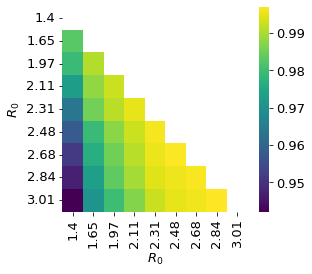

In [20]:
title='$s_i$ ranking corr.'
figname = '../figs/spreader_rank_corr_%s_mu_%.2f.pdf'%(dataset,mu)

plot_sim(corr_s, 
         mu, 
         R0_range,
         '$R_0$',
         save=True, 
         figname=figname, 
         scale='independent',
         min_scale=0, 
         max_scale=1)

# Receiver vs. spreader

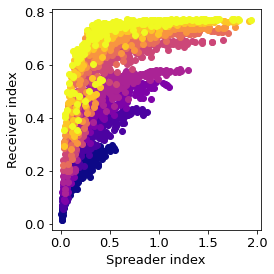

In [26]:
fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize=(4,4))

colors = plt.cm.plasma(np.linspace(0,1,len(beta_range)))
for i in range(len(beta_range)):
    plt.plot(np.array(s_list[i]),
             np.array(r_list[i]),
             'o',
             c=colors[i],
             label=r'%.2f'%beta_range[i])
plt.xlabel('Spreader index')
plt.ylabel('Receiver index')
plt.tight_layout()
#plt.legend(title='$R_0$',ncol=2)
plt.savefig('../figs/r_s_simple_%s.pdf'%(dataset))
#plt.savefig('../figs/legend_r_s.pdf')
plt.show()